##### **<font color="orange"> 문자열 길이 기준으로 drop </font>**

In [1]:
import pandas as pd

df = pd.read_csv('./dataset/train.csv')
df.head(5)

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [2]:
print("train dataset count : ", len(df))

train dataset count :  9324


In [3]:
df['source'].unique()

array(['nsmc-sampled', 'slack-rtt', 'petition-sampled', 'slack-sampled',
       'nsmc-rtt', 'petition-rtt'], dtype=object)

In [4]:
sentence_1_length = df['sentence_1'].map(len)
sentence_2_length = df['sentence_2'].map(len)

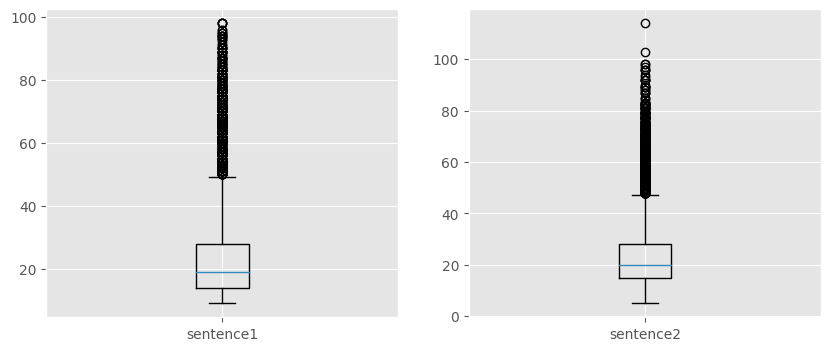

In [5]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].boxplot(sentence_1_length)
ax[0].set_xticks([1], ['sentence1'])
ax[1].boxplot(sentence_2_length)
ax[1].set_xticks([1], ['sentence2'])

plt.show()

In [6]:
q1, q3 = sentence_1_length.quantile(q=[0.25, 0.75])
iqr = q3 - q1

sentence_1_upper_bound = q3 + (1.5 * iqr)

In [7]:
q1, q3 = sentence_2_length.quantile(q=[0.25, 0.75])
iqr = q3 - q1

sentence_2_upper_bound = q3 + (1.5 * iqr)

In [8]:
print(len(sentence_1_length[sentence_1_length > sentence_1_upper_bound].index))
print(len(sentence_2_length[sentence_2_length > sentence_2_upper_bound].index))

599
587


In [9]:
s1 = sentence_1_length[sentence_1_length > sentence_1_upper_bound].index
s1

Int64Index([  24,   25,   27,   34,   63,   64,  113,  133,  136,  145,
            ...
            9142, 9150, 9159, 9201, 9216, 9222, 9259, 9264, 9296, 9312],
           dtype='int64', length=599)

In [10]:
s2 = sentence_2_length[sentence_2_length > sentence_2_upper_bound].index
s2

Int64Index([  24,   25,   27,   34,   63,   64,   65,   85,  113,  136,
            ...
            9150, 9201, 9216, 9234, 9259, 9264, 9271, 9281, 9311, 9312],
           dtype='int64', length=587)

In [11]:
len(s1[~s1.isin(s2)])

176

In [12]:
len(s1.intersection(s2))

423

In [13]:
s1_ids = sentence_1_length[sentence_1_length > sentence_1_upper_bound].index

In [14]:
s2_ids = sentence_2_length[sentence_2_length > sentence_2_upper_bound].index

In [15]:
s1_ids = pd.Series(s1_ids)
s2_ids = pd.Series(s2_ids)

concat_ids = pd.concat([s1_ids, s2_ids])
concat_ids.count()

1186

In [16]:
concat_ids = concat_ids.drop_duplicates()
concat_ids.count()

763

In [17]:
df.drop(index=concat_ids, inplace=True)

In [18]:
df.to_csv('dataset/train_iqr.csv', index=False)

<br><br>

##### **<font color="orange">tokenizer</font>**

In [19]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path='klue/roberta-small',
)

/root/miniconda3/envs/sementic_text_similarity/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
tokenizer.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [21]:
data = []
for idx, item in df.iterrows():
    text = '[SEP]'.join([item[text_column] for text_column in ['sentence_1', 'sentence_2']])
    outputs = tokenizer(text, add_special_tokens=True)
    data.append(outputs['input_ids'])

In [22]:
data_length = pd.Series([len(d) for d in data])
data_length.max()

67

In [24]:
(data_length >= 64).value_counts()

False    8560
True        1
dtype: int64

In [25]:
data_length[data_length >= 64]

744    67
dtype: int64

In [26]:
df.loc[744, :]

id              boostcamp-sts-v1-train-744
source                        nsmc-sampled
sentence_1         한번쯤 이런 인연을 만나는 것도 복이지..
sentence_2           가끔 이런 영화도 필요한 법이야..~!
label                                  0.0
binary-label                           0.0
Name: 744, dtype: object

In [27]:
df.drop(index=744, inplace=True)
df.to_csv('dataset/train_tokenizer_len.csv', index=False)